# Разработка решения для увеличения покупательской активности постоянных клиентов ИМ

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. 

Целью исследования является разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


1. Для достижения цели построим модель, которая предсказывает вероятность снижения покупательской активности клиента в следующие три месяца и оценим какие входные признаки больше всего влияют на снижение активности.
2. В исследование будут включены дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, будут выделены сегменты покупателей и разработаны для них персонализированные предложения.

## Знакомство с данными


In [1]:
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install seaborn --upgrade -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install missingno -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install scikit-learn -q

In [5]:
!pip install shap -q

In [6]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import phik
import shap
import warnings
import sklearn
import math
import missingno as msno
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, 
                                   StandardScaler, MinMaxScaler, 
                                   RobustScaler, LabelEncoder)
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import RandomOverSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


warnings.filterwarnings("ignore")

Функции, используемые в работе.

In [7]:
# Функция для построения гистограмм
def plot_histograms(df, columns, rows=2):
    """
    Строит гистограммы для указанных числовых столбцов в DataFrame.

    Args:
        df: DataFrame с данными.
        columns: Список названий числовых столбцов.
        rows: Количество рядов в сетке графиков.
    """
    num_plots = len(columns)
    cols = num_plots // rows + (num_plots % rows > 0)  
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  # Преобразуем массив осей в одномерный список

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_ylabel('Количество')

    plt.tight_layout()
    plt.show()


#Функция для загрузки дата сета

def loading_data(file_name, 
                 df_name, sep=',', 
                 graf=True, 
                 missingno=False, 
                 figsize=(15,10), 
                 bins=30):
    
    try:
        df = pd.read_csv('../assets/'+  file_name, sep=sep, decimal=",") 
    except:
        df = pd.read_csv('/datasets/' + file_name, sep=sep, decimal=",") 
    
    pd.set_option("display.max_columns", None)
    
    print(df_name)
    display(df.head(5))
    print('-'*80)
    print('Общая информация о наборе данных, индекс, столбцы ',
          'и тип данных, нулевые значения и использование памяти ')
    print()
    print(df.info())
    print('-'*80)
    print('Оценим количество пропущенных значений в каждом столбце')
    print()
    display(df.isna().sum())
    
    if missingno == True:
        print('-'*80)
        print('Визуализируем пропуски в данных')
        msno.matrix(df, figsize = (10,8))
    if graf == True:
        plt.show()
        print('-'*80)
        print('Визуализируем общие данные')
        if 'id' in df.columns:
            df_new = df.drop(columns=['id'])
        else:
            df_new = df

        # Вызываем функцию, указав желаемое количество рядов
        numeric_cols = df_new.select_dtypes(include=['number']).columns
        rows = math.ceil(len(numeric_cols)/3)
        
        if len(numeric_cols) == 1:
            df_new[numeric_cols].hist()
        else:
            plot_histograms(df_new, numeric_cols, rows=rows)
        plt.show()
     
    return df

In [8]:
#Предобработка, удаление явных дубликатов
def remove_duplicates(data, title):
    num_duplicates = data.duplicated().sum()
    if num_duplicates != 0:
        print('Количество явных дубликатов в ',
               title, ':', data.duplicated().sum())
        print('Размер', title, 'до удаления дубликатов:', data.shape)
        data = data.drop_duplicates(keep = 'first')
        print('Размер', title, 'после удаления дубликатов:', data.shape)
        return data
    else:
        print('Явные дубликаты в', title, 'отсутсвуют')
        return data

In [9]:
def my_plot(data, my_title, bins=50, xlabel='Значение', hue=None):
    # Создаем фигуру с двумя графиками в одном ряду
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Гистограмма с использованием Seaborn
    sns.histplot(
        x=data,
        hue=hue,
        bins=bins,
        ax=ax1,
        kde=False,
        multiple='layer',
        palette="Set1"
    )
    ax1.set_title(f'Гистограмма распределения {my_title}')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Частота')
    ax1.grid(True)
    
    # Добавляем линии среднего и медианы только если нет разделения по hue
    if hue is None:
        mean_val = data.mean()
        median_val = data.median()
        ymax = ax1.get_ylim()[1]
        ax1.vlines(
            x=[mean_val, median_val],
            ymin=0,
            ymax=ymax,
            colors='red',
            linestyles=['-', '--'],
            label=['Среднее', 'Медиана']
        )
        ax1.legend()
    
    # Boxplot с использованием Seaborn
    if hue is None:
        sns.boxplot(x=data, ax=ax2, orient='h', color='skyblue')
    else:
        sns.boxplot(
            x=data,
            y=hue,
            ax=ax2,
            orient='h',
            palette='Set1'
        )
    
    ax2.set_title(f'Ящик с усами для {my_title}')
    ax2.set_xlabel(xlabel)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
def my_bar(data, my_title):
    counts = []
    labels = []
    for i in data.unique():
        labels.append(i)
        count = data.loc[data == i].count()
        counts.append(count)
    
    # Рассчитаем проценты для подписей
    total = sum(counts)
    percentages = [(count / total) * 100 for count in counts]

    # Создаем столбчатую диаграмму
    plt.bar(labels, counts, color=sns.color_palette('Set2'))
    
    # Добавляем подписи с процентами
    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        plt.text(i, count, f'{percentage:.2f}%', 
                 ha='center', 
                 va='bottom',
                 fontsize=10)

    # Настройка заголовка и меток
    plt.title(f'{my_title}', fontsize=14)
    plt.xlabel('Категории')
    plt.xticks(
        rotation=45, 
        ha='right', 
        fontsize=10, 
        rotation_mode='anchor'
    )
    plt.ylabel('Количество')


______________________________

market_file


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы  и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


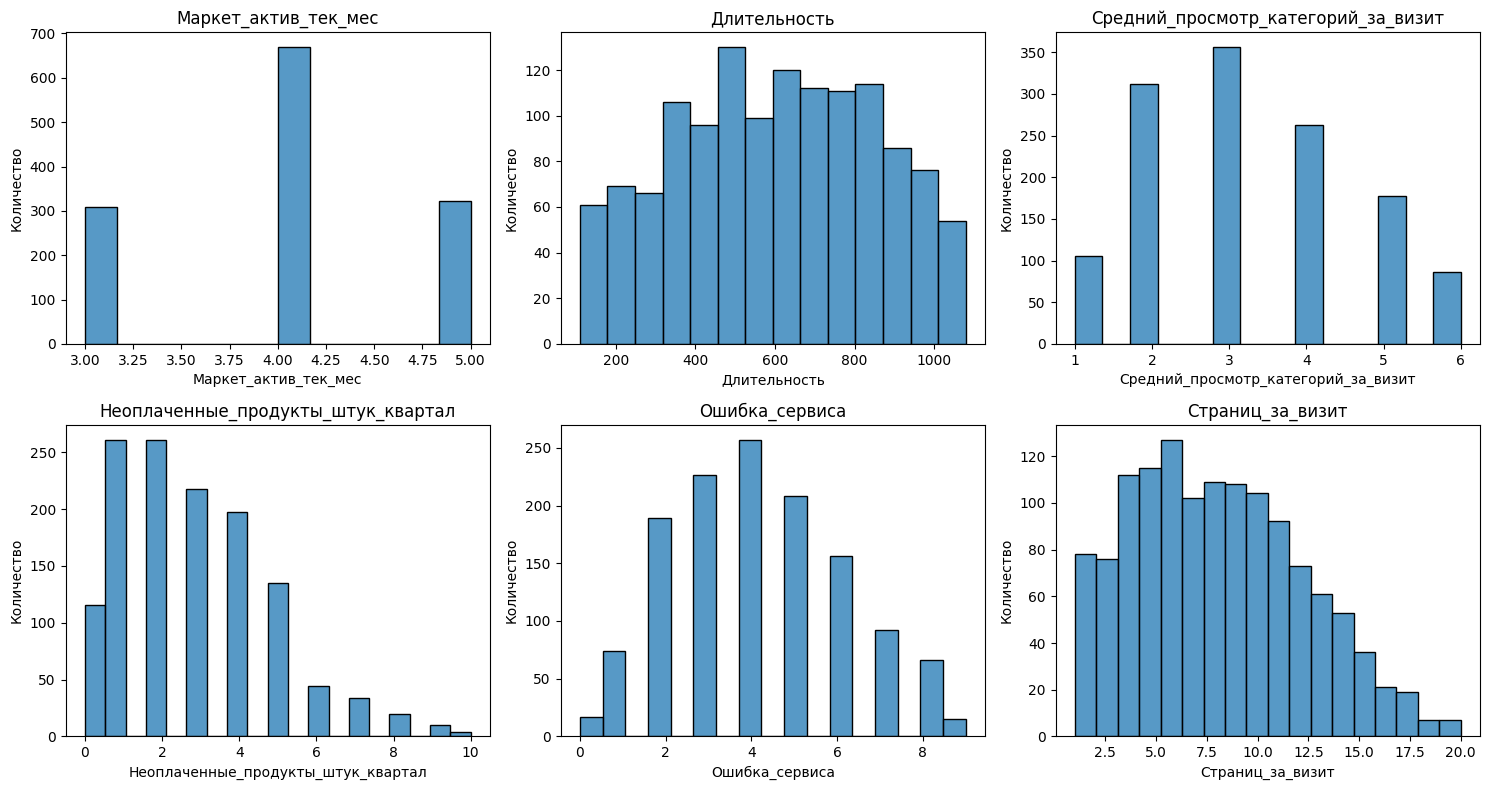

In [11]:
market_file = loading_data('market_file.csv', 'market_file', sep=',')

In [12]:
market_money = loading_data('market_money.csv', 
                            'market_money', 
                            sep=',', 
                            missingno=False, 
                            graf=False, 
                            figsize=(5, 2))

market_money


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы  и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id         0
Период     0
Выручка    0
dtype: int64

market_time


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы  и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id        0
Период    0
минут     0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


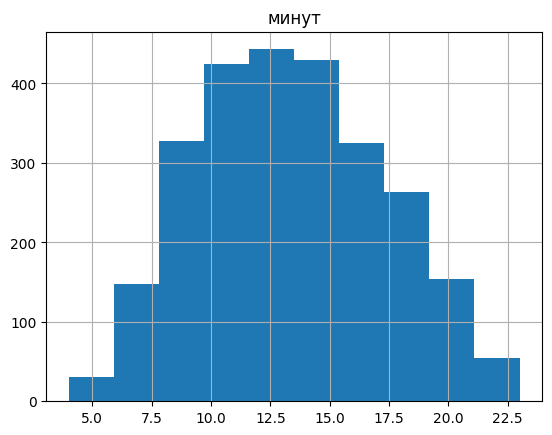

In [13]:
market_time = loading_data('market_time.csv', 
                           'market_time', 
                           missingno=False, 
                           figsize=(5,2))

money


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы  и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id         0
Прибыль    0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


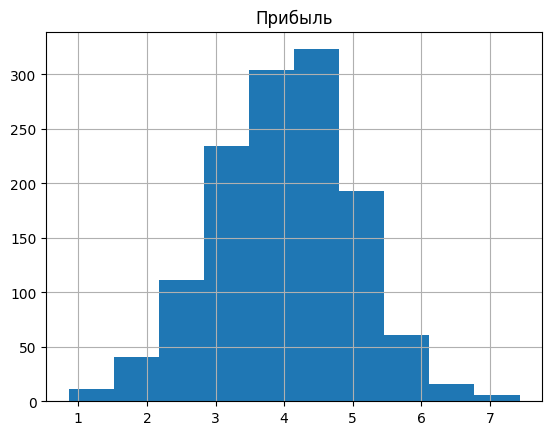

In [14]:
money = loading_data('money.csv', 'money', sep=';', missingno=False)

Общая предварительная оценка данных:

- набор данных достаточен для анализа
- пропуски отсутсвуют
- присутсвуют неправильные типы данных
- выборка репрезентативна.
- присутсвуют аномалии и выбросы

## Предобработка данных

### Изменение названия столбцов

Название столбцов оставим на кириллице, но приведем к виду snake_case

In [15]:
dfs = [
    market_file,
    market_money,
    market_time,
    money
]
for df in dfs:
    df.columns = [
        re.sub(r'(?<!^)(?=[A-Z])| ', '_', i).lower() for i in df.columns]

In [16]:
print(market_file.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')


###  Изменение типа данных

In [17]:
market_file[['маркет_актив_6_мес', 
             'акционные_покупки']] = (market_file[['маркет_актив_6_мес', 
                                                  'акционные_покупки']]
                                                  .astype(float))
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [18]:
market_money['выручка'] = market_money['выручка'].astype(float)
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [19]:
money['прибыль'] = money['прибыль'].replace(',', '.')
money.head(3)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


In [20]:
money['прибыль'] = money['прибыль'].astype(float)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Удаление явных и скрытых дубликатов

In [21]:
market_file = remove_duplicates(market_file, 'market_file')
market_money = remove_duplicates(market_money, 'market_money')
market_time = remove_duplicates(market_time, 'market_time')
money = remove_duplicates(money, 'money')

Явные дубликаты в market_file отсутсвуют
Явные дубликаты в market_money отсутсвуют
Явные дубликаты в market_time отсутсвуют
Явные дубликаты в money отсутсвуют


In [22]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [23]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 
                                                                'стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [24]:
market_file['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [25]:
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [26]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [27]:
market_time.head(2)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


In [28]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [29]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц',
                                                      'предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

В ходе предобработки:

- данные проверены на наличие явных дубликаты.
- скрытые дубликаты удалены. 
- тип данных изменен в датафрейме money в столбце прибыль.
- названия столбцов оставлены без изменений, но приведены к нижнему регистру.


# Исследовательский анализ данных

In [30]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


- Маркетинговая активность за 6 месяцев принимает значения от 0 до 7
- Максимальное значение макретинговой активности в текущем месяце не превышает 5, медиана 4. Т.е. остается резерв для маркетингового взаимодействия с покупателями без злоупотребелния со стороны магазина.
- Акционные покупки принимают значения от 0 до 1 (Стоит учесть данное замечание перед кодированием данных для обучения модели)
- В столбце страниц за визит и неоплаченные продукты штук в квартал имеют выбросы по верхней границе.

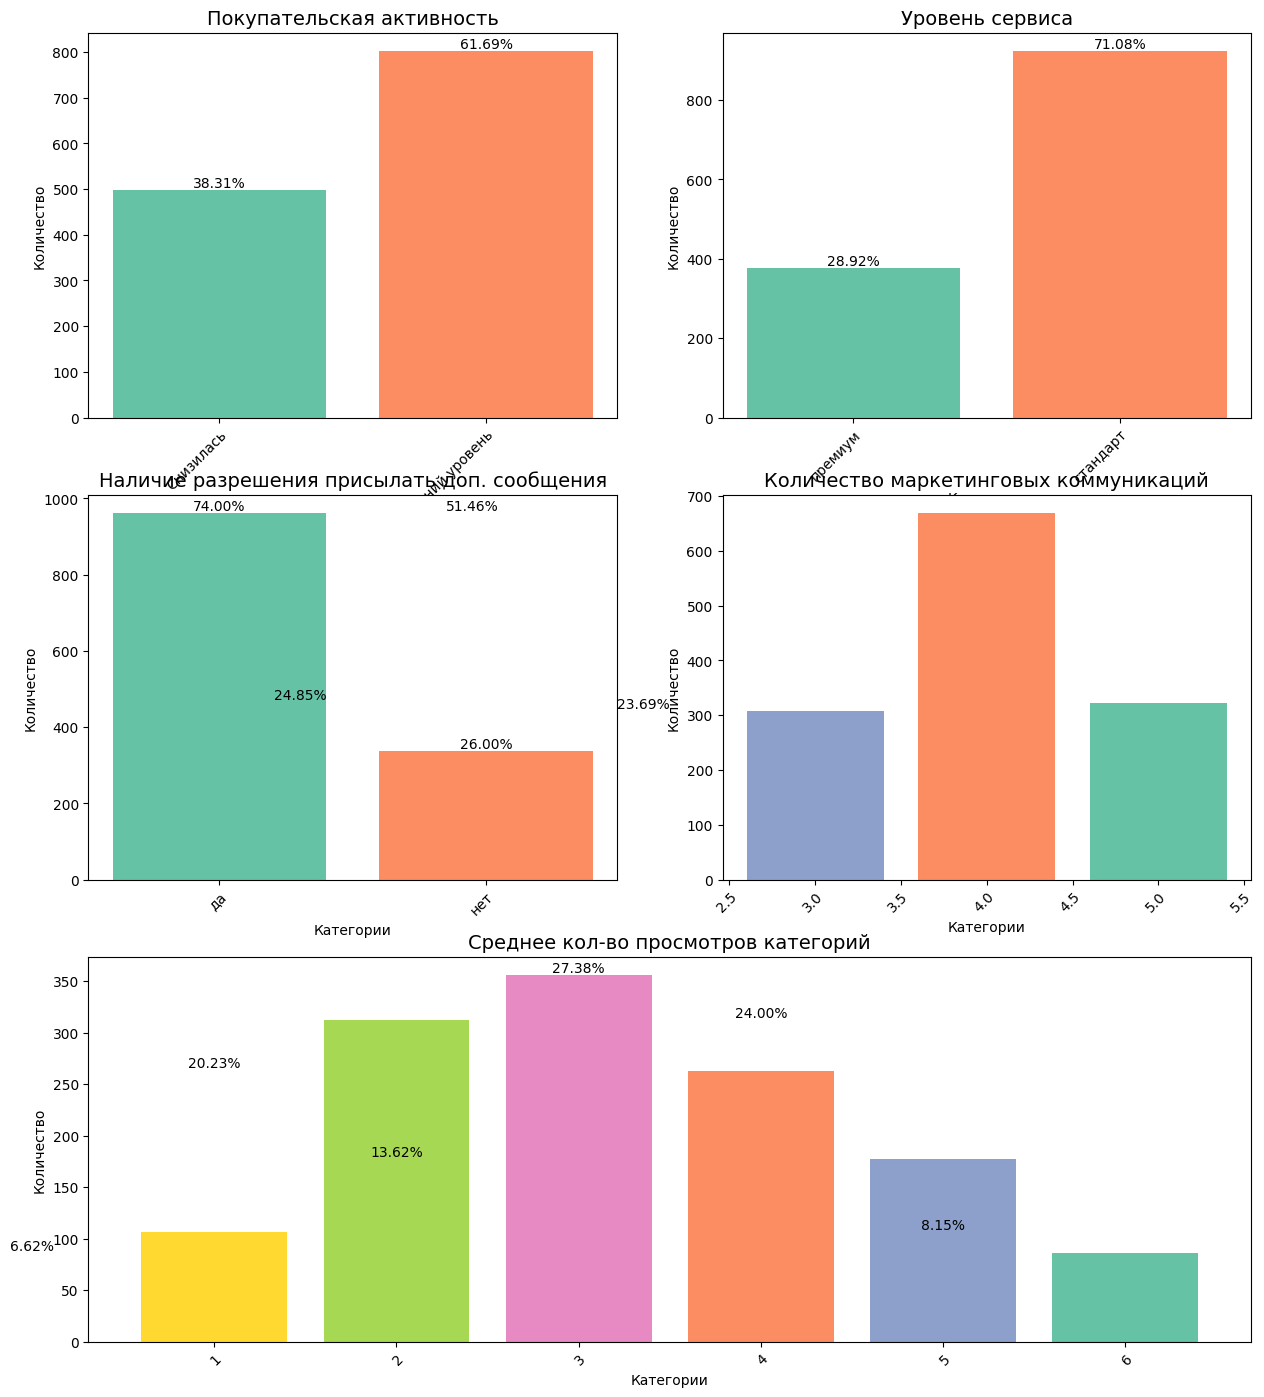

In [31]:
plt.figure(figsize=(15,17))
plt.subplot(3, 2, 1)
my_bar(market_file['покупательская_активность'], 
       'Покупательская активность')

plt.subplot(3, 2, 2)
my_bar(market_file['тип_сервиса'], 'Уровень сервиса')

plt.subplot(3,2,3)
my_bar(market_file['разрешить_сообщать'], 
       'Наличие разрешения присылать доп. сообщения')

plt.subplot(3,2,4)
my_bar(market_file['маркет_актив_тек_мес'], 
       'Количество маркетинговых коммуникаций')

plt.subplot(3,1,3)
my_bar(market_file['средний_просмотр_категорий_за_визит'], 
       'Среднее кол-во просмотров категорий')

plt.show()


На лицо дисбаланс классов по целевому признаку. Минорный класс - покупательская активность снизилась.

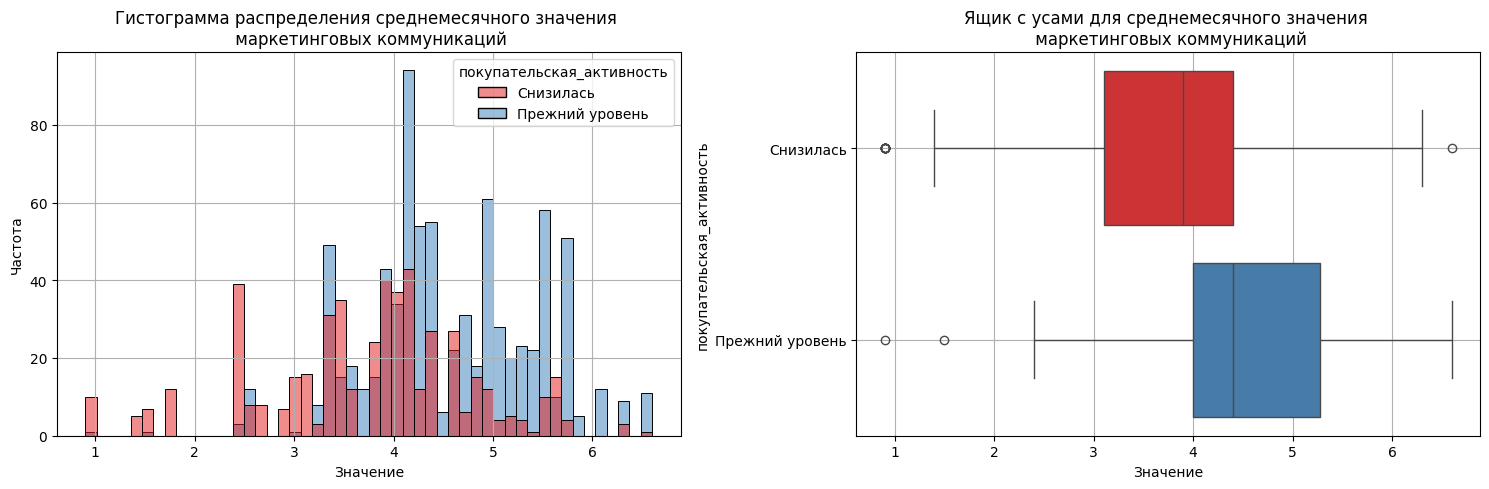

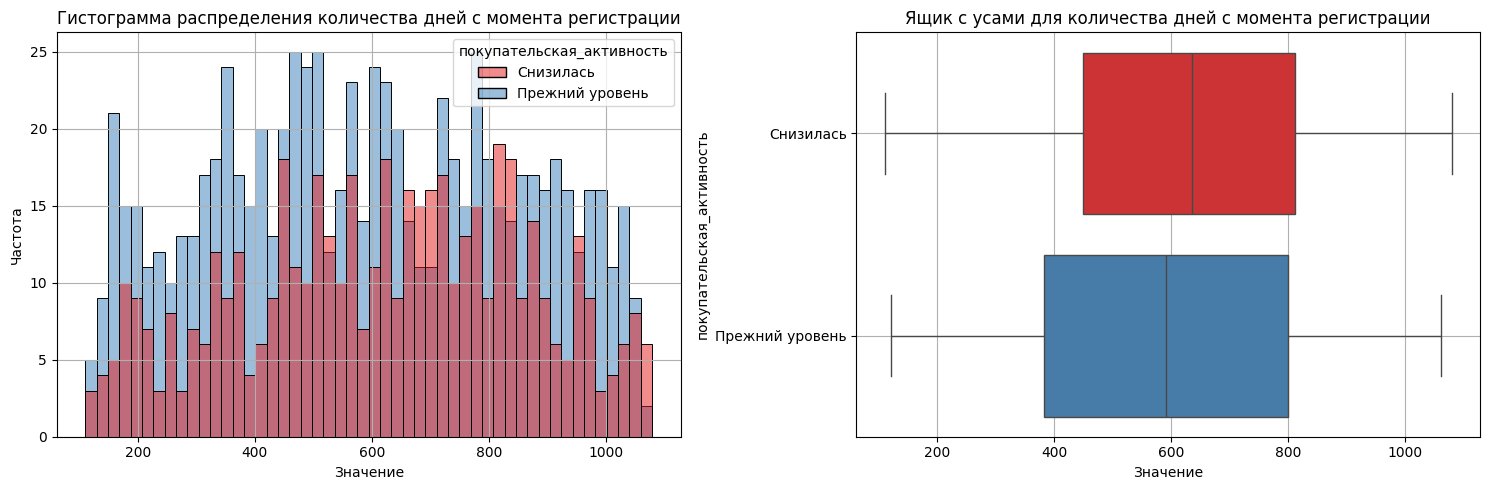

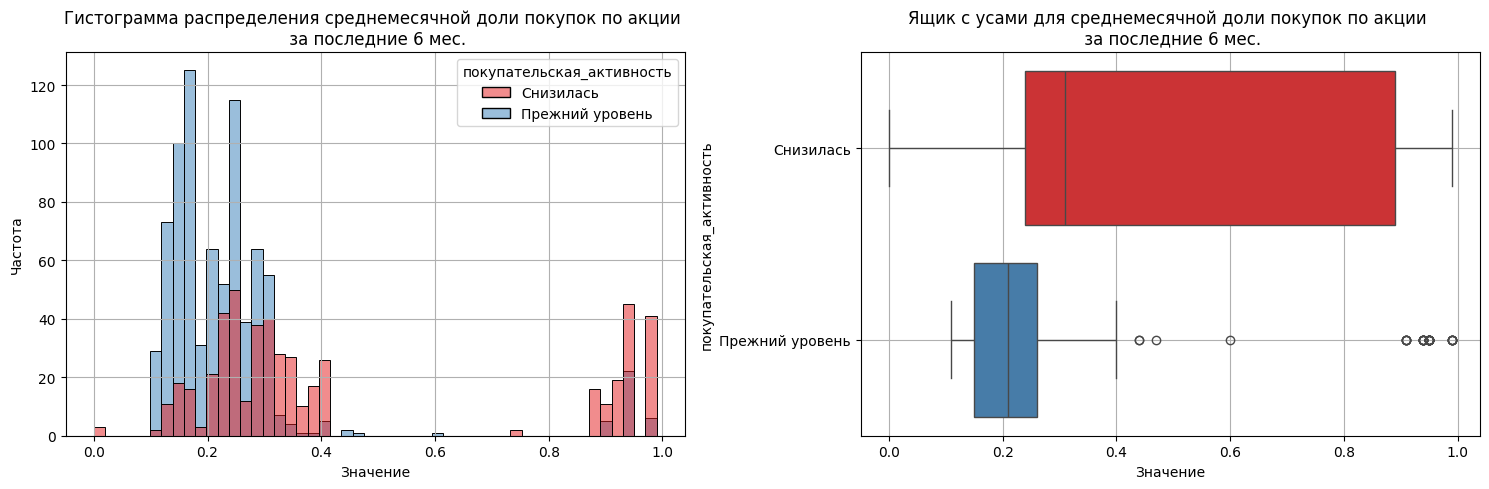

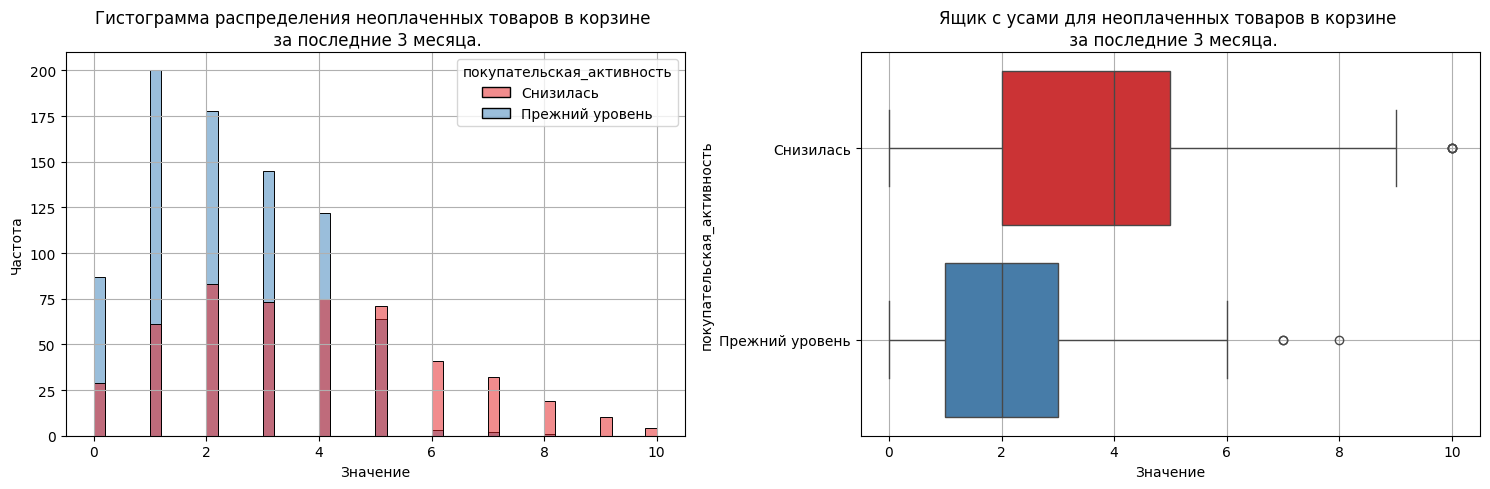

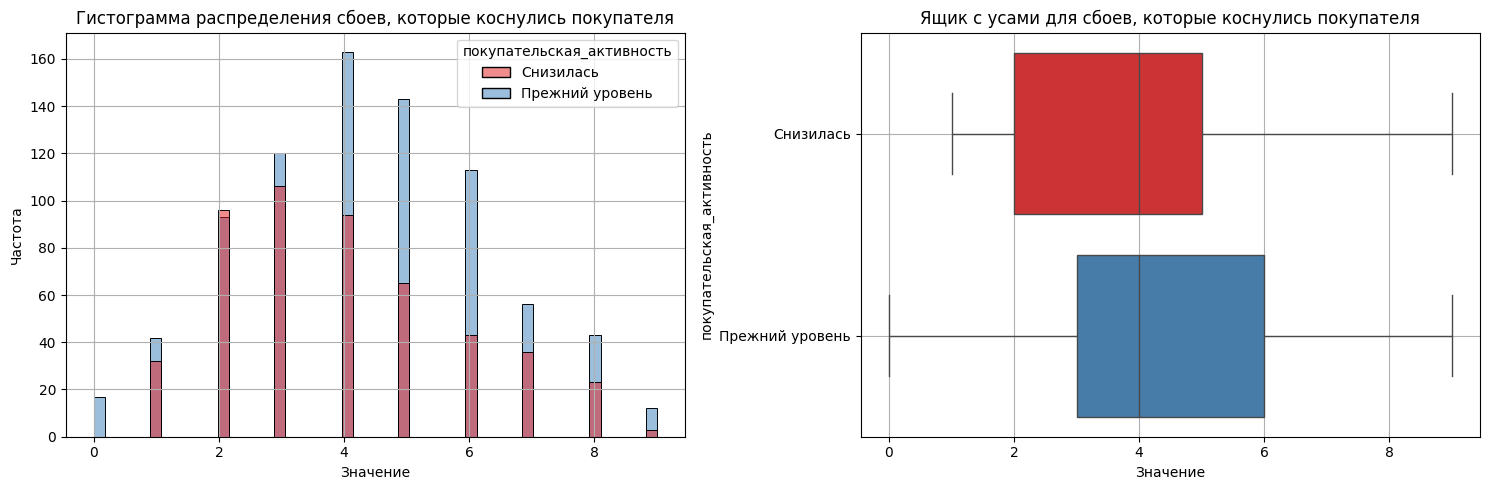

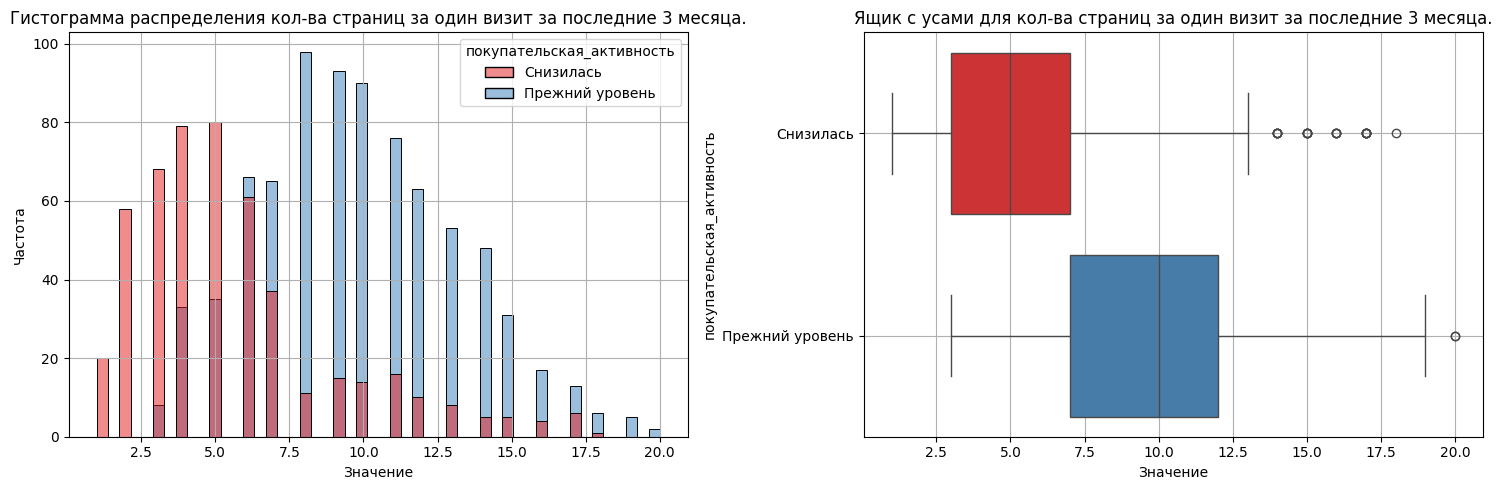

In [32]:
my_plot(market_file['маркет_актив_6_мес'], 
        my_title='среднемесячного значения \n маркетинговых коммуникаций', 
        hue=market_file['покупательская_активность'],
        bins=50)

my_plot(market_file['длительность'],  
        my_title='количества дней с момента регистрации', 
        hue=market_file['покупательская_активность'],
        bins=50)

my_plot(market_file['акционные_покупки'], 
        my_title='среднемесячной доли покупок по акции \n за последние 6 мес.',
        hue=market_file['покупательская_активность'])

my_plot(market_file['неоплаченные_продукты_штук_квартал'], 
        my_title='неоплаченных товаров в корзине \n за последние 3 месяца.',
        hue=market_file['покупательская_активность'])

my_plot(market_file['ошибка_сервиса'],
        my_title='сбоев, которые коснулись покупателя',
        hue=market_file['покупательская_активность'])

my_plot(market_file['страниц_за_визит'], 
        my_title='кол-ва страниц за один визит за последние 3 месяца.',
        hue=market_file['покупательская_активность'])

Наблюдаются отдельные значения за пределами ящиков с усами. Данные значения не являются выбросами (ошибочными значениями), а скорее аномалии, которые имеют место быть в жизни.

Два пика на гистограмме рассеяния среднемесячной доли покупок по акции за последние 6 месяцев имеет 2 пика. С учетом расположения пиков можно сделать вывод, что есть существенная группа покупателей, которые делают покупки преимущественно акционных товаров.

Датасет market_file 

- Рассчитанный целевой признак (покупательская активность) имеет соотноешение 38 к 62%. Минорный класс покупательская активность снизилась.
- По уровню сервиса 29% клиенты премиум сервиса, остальные стандартного.
- 26% покупателей не дали разрешения на получение дополнительных сведений о товаре. 
- Маркетинговая активность за последние 6 мес - наблюдаются аномальные значения справа.
- Среднее значение и мода меркетинговых коммуницаций за последний месяц равна 4. Можно сказать, что за последний месяц маркетинговая компания не менялась (сравнивая гистограммы за послдение 6 месяцев и прошедший месяц)
- Гистограмма количества дней с момента регистрации похожа на нормальное распределения. Среднее значение чуть менее 2 лет. 
- Гистограмма среднемесячной доли покупок по акции от общего числа покупок имеет 2 пика. Один в районе 0.3, второй ближе к единице. Что говорит о наличии существенной группы покупателей делающих покупки исключительно по акции.
- За последний месяц в среднем просматривалось 3 категории товаров. Максимально 6.
- Гистограмма количества неоплаченных продуктов за последние 3 месяца имеет вид распределения Пуассона. Медиана 2.
- Гистограмма сбоев, которые коснулись покупателей имеет вид нормального распределения. Среднее значение 4. 
- Гистограмма распределения среднего количества страниц за визит похожа на нормальное распределение со смещением влево. Медиана 8, 

In [33]:
market_money.groupby('период')['выручка'].describe().T

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000,1300.000000
mean,4936.920385,4825.206923,5314.960846
std,739.597997,405.979663,2939.708156
min,0.000000,0.000000,2758.700000
25%,4496.750000,4583.000000,4706.050000
50%,5005.000000,4809.000000,5179.950000
75%,5405.625000,5053.500000,5761.725000
max,6869.500000,5663.000000,106862.200000


Удалим из данных покупателей, которые не делали покупок хотя бы в одном из трех месяцев

In [34]:
zero_money = market_money.query('выручка == 0')
zero_money = pd.pivot_table(zero_money, 
                            index='id', 
                            values='выручка', 
                            aggfunc='sum').reset_index()
zero_money = list(zero_money['id'])
zero_money

[215348, 215357, 215359]

In [35]:
market_money = market_money.query('id != @zero_money')
market_money.shape


(3891, 3)

In [36]:
market_money.head()

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


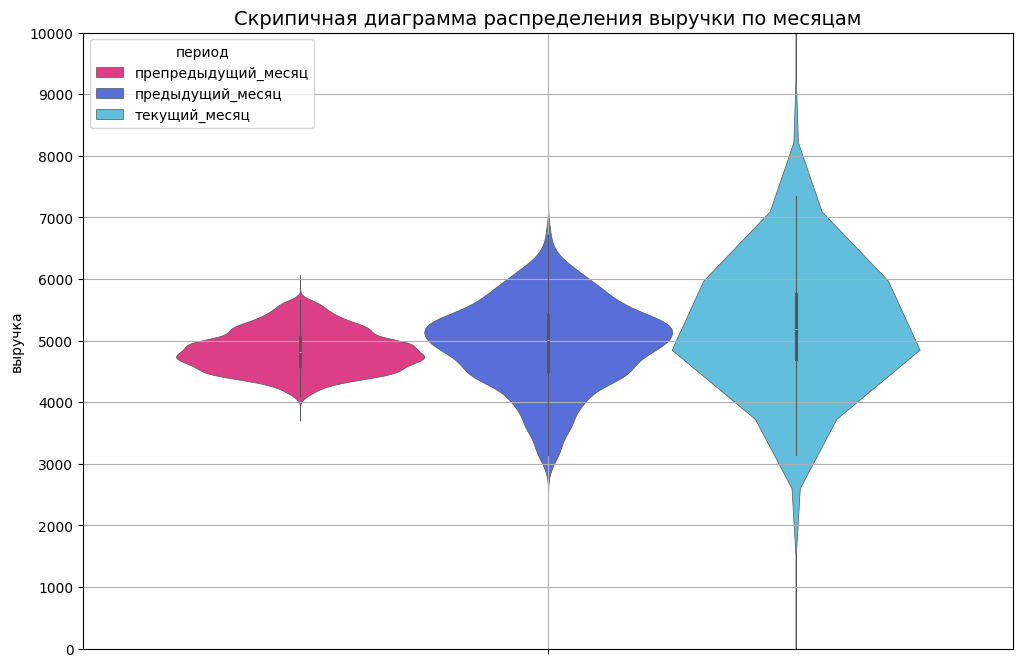

In [37]:
# Настройка стиля и параметров
plt.figure(figsize=(12, 8))
custom_palette = ["#F72585", "#4361EE", "#4CC9F0", "#7209B7", "#3A0CA3"]
ax = sns.violinplot(data=market_money, 
                    y= market_money['выручка'].sort_values(ascending=True), 
                    hue=market_money['период'],
                    hue_order=['препредыдущий_месяц',
                               'предыдущий_месяц',
                               'текущий_месяц'],
                    palette=custom_palette, 
                    bw=.2, 
                    cut=6, 
                    linewidth=0.5 )
plt.title("Скрипичная диаграмма распределения выручки по месяцам", fontsize=14)
ax.yaxis.set_major_locator(plt.MaxNLocator(10)) 
plt.ylim(0,10000)
plt.grid(True)
plt.show()

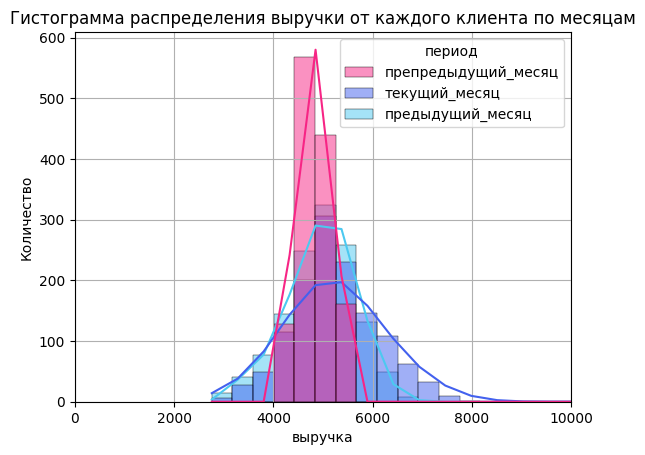

In [38]:
ax = plt.figure()
sns.histplot(market_money,
             x=market_money['выручка'],
            hue=market_money['период'],
            bins=250,
            palette=custom_palette,
            linewidth=0.3,
            kde=True)
plt.title('Гистограмма распределения выручки от каждого клиента по месяцам')

plt.ylabel('Количество')
plt.xlim(0,10000)
plt.grid(True)
plt.show()

In [39]:
market_time.groupby('период')['минут'].describe().T

период,предыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000
mean,13.467692,13.204615
std,3.932029,4.220589
min,5.000000,4.000000
25%,11.000000,10.000000
50%,13.000000,13.000000
75%,17.000000,16.000000
max,23.000000,23.000000


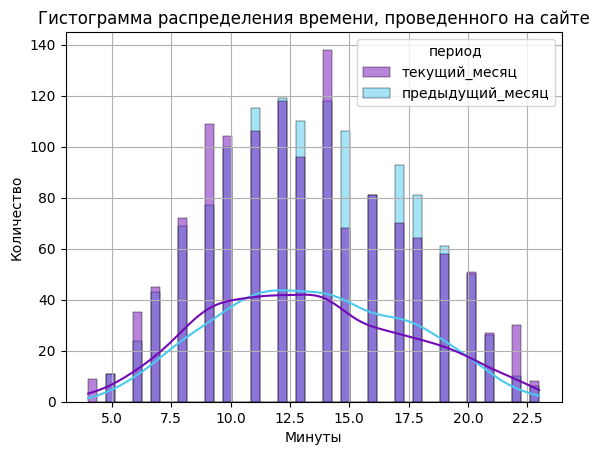

In [40]:
sns.histplot(market_time, 
             x=market_time['минут'], 
             hue=market_time['период'], 
             bins=50, palette=["#7209B7", "#4CC9F0"], linewidth=0.3, kde=True)
plt.title('Гистограмма распределения времени, проведенного на сайте')
plt.ylabel('Количество')
plt.xlabel('Минуты')
plt.grid()
plt.show()

In [41]:
money.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


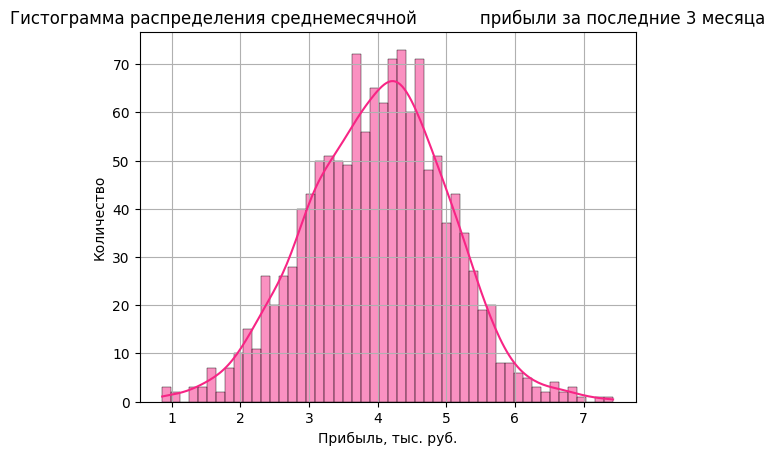

In [42]:
sns.histplot(money, 
             x=money['прибыль'], 
             bins=50, 
             color="#F72585", 
             linewidth=0.3, 
             kde=True)
plt.title('Гистограмма распределения среднемесячной \
           прибыли за последние 3 месяца')
plt.ylabel('Количество')
plt.xlabel('Прибыль, тыс. руб.')
plt.grid()
plt.show()

market_money

- Размах гистограммы выручки от каждого клиента по месяцам имеетвид нормального распределения. Самый большой размах наблюдается в текущем месяце. 
- Выбросы в данных удалены
- Скрипичная диаграмма распределения показывает увеличение выручки от постоянных клиентов от месяца к месяцу.
- Наблюдаюстя покупатели, которые не совершали покупки в предпредыдущем месяце или предыдущем, но решились на покупку в текущем.
- Отобраны покупатели, которые совершали покупки последние 3 месяца.

market_time 

- Среднее время, которое покупатель проводит на сайте 13 минут. 
- За последний месяц наблюдается небольшое изменение в меньшую сторону (значения 25 и 75 квартилей на 1 минуту меньше).
- Гистограмма имеет нормальное распределение.

money

1. Гистограмма имеет нормальное распределение, медиана 4 тыс. руб.

## Объединение данных

In [43]:
market_money.head()

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [44]:
market_money_pivot = pd.pivot_table(market_money, 
                              index=['id'], 
                              columns=['период'], 
                              values='период', 
                              aggfunc='sum').reset_index()
market_money_pivot.head()

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [45]:
market_money_pivot = market_money_pivot.reindex(columns=[
    'id', 
    'препредыдущий_месяц', 
    'предыдущий_месяц', 
    'текущий_месяц'])
market_money_pivot = market_money_pivot.rename(columns={
    'препредыдущий_месяц': 'выручка_препредыдущий_месяц',
    'предыдущий_месяц': 'выручка_предыдущий_месяц',
    'текущий_месяц': 'выручка_текущий_месяц'})

market_money_pivot.head()

период,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5


In [46]:
market_money_pivot.shape

(1297, 4)

In [47]:
market_file.shape

(1300, 13)

In [48]:
data = pd.merge(market_file, market_money_pivot, on=['id','id'], how='inner' )
data.head(2)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4


In [49]:
data.shape

(1297, 16)

In [50]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [51]:
market_time_pivot = pd.pivot_table(market_time, 
                                   index=['id'], 
                                   columns=['период'], 
                                   values='период', 
                                   aggfunc='sum').reset_index()
market_time_pivot = market_time_pivot.rename(columns={
    'предыдущий_месяц': 'длительность_предыдущий_месяц', 
    'текущий_месяц': 'длительность_текущий_месяц'})
market_time_pivot.head()

период,id,длительность_предыдущий_месяц,длительность_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [52]:
market_time_pivot.shape

(1300, 3)

In [53]:
data = pd.merge(data, market_time_pivot, on=['id','id'], how='inner' )
data.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,длительность_предыдущий_месяц,длительность_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

Данные объединены в один датасет. Очищены от выбросов, пропуски отсутсвуют, все покупатели делали покупки последние 3 месяца.

## Корреляционный анализ

In [55]:
data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,длительность_предыдущий_месяц,длительность_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [56]:
corr_market = data[
    [
    'тип_сервиса', 
    'разрешить_сообщать', 
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'покупательская_активность' 
    ]
    ].phik_matrix(
        interval_cols=
        [
        'маркет_актив_6_мес', 
        'маркет_актив_тек_мес', 
        'длительность'
        ]
        )
corr_product = data[
    [
    'популярная_категория', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'акционные_покупки',
    'покупательская_активность'
    ]
    ].phik_matrix(
        interval_cols=
        [
        'средний_просмотр_категорий_за_визит',
        'акционные_покупки',
        'неоплаченные_продукты_штук_квартал'
        ]
        )
corr_web = data[
    [
    'длительность_предыдущий_месяц', 
    'длительность_текущий_месяц', 
    'страниц_за_визит', 
    'ошибка_сервиса',
    'покупательская_активность'
    ]
    ].phik_matrix(
        interval_cols=
        [
        'ошибка_сервиса',
        'страниц_за_визит', 
        'длительность_предыдущий_месяц', 
        'длительность_текущий_месяц'
        ]
        )
corr_money = data[
    [
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц', 
    'покупательская_активность'
    ]
    ].phik_matrix(
        interval_cols=
        [
        'выручка_препредыдущий_месяц',
        'выручка_предыдущий_месяц', 
        'выручка_текущий_месяц'
        ]
        )

In [57]:
data.shape

(1297, 18)

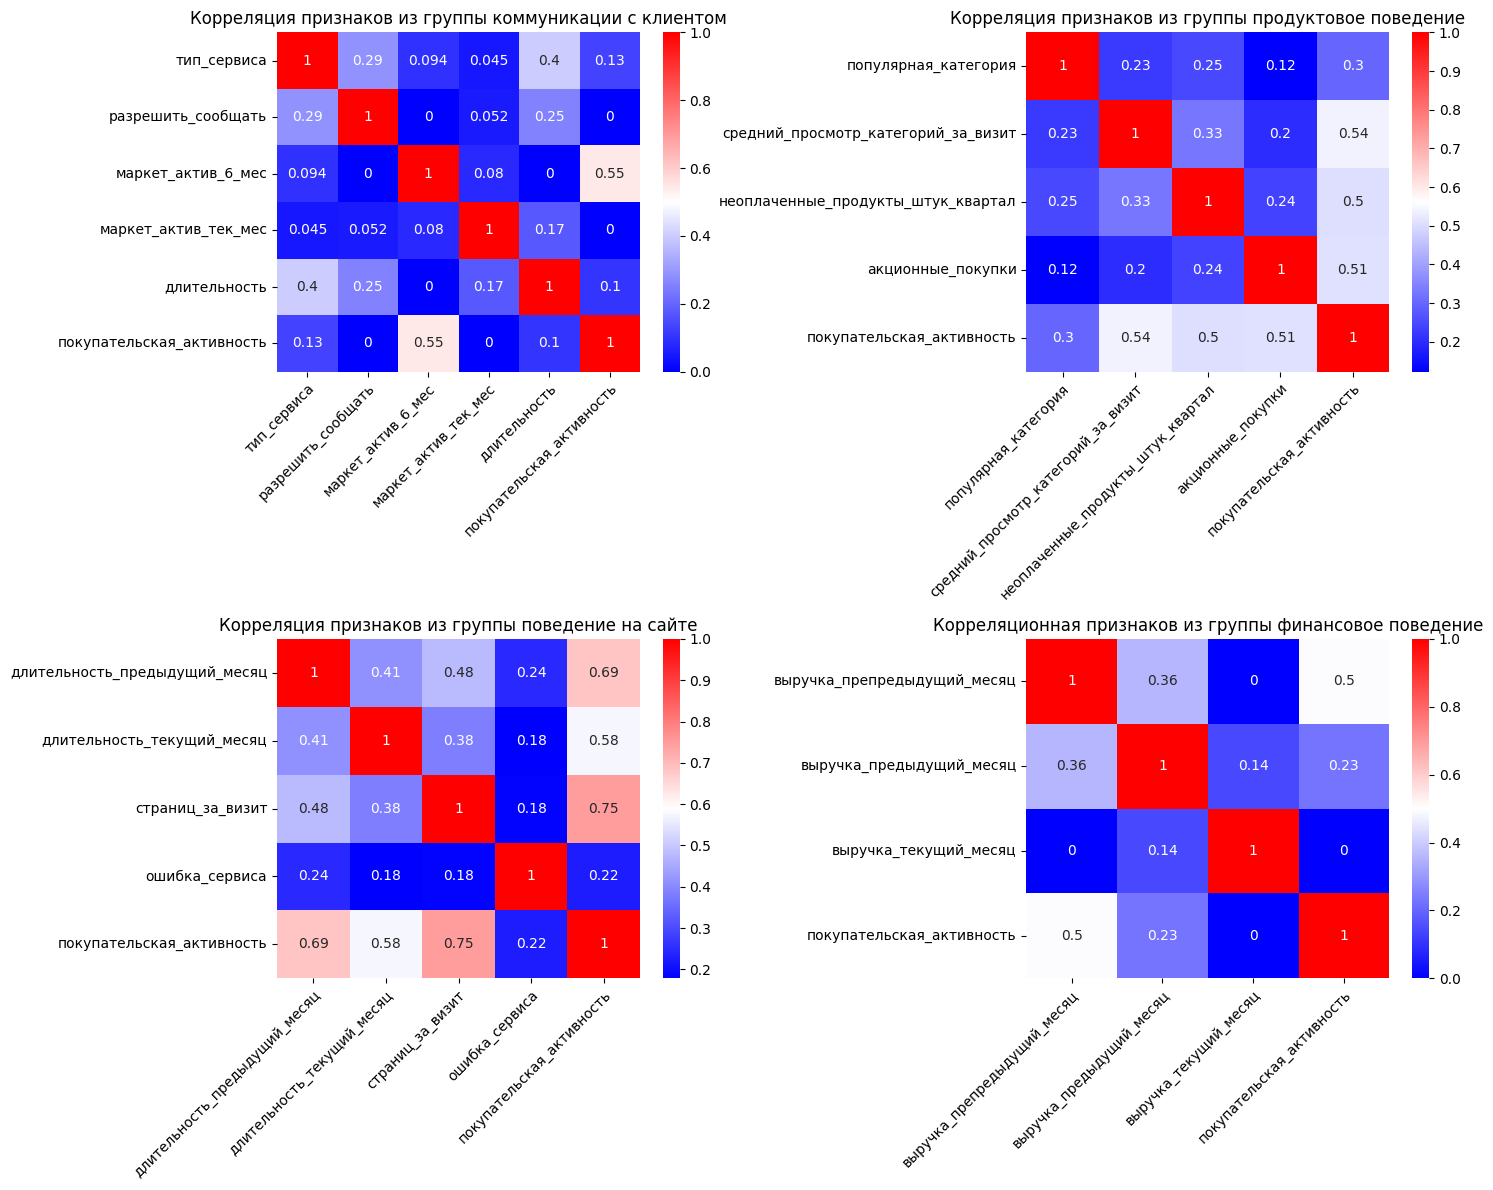

In [58]:
fig = plt.figure(figsize=(15,12))

ax1=plt.subplot(2, 2, 1)
ax1 = sns.heatmap(corr_market, 
                  annot=True, 
                  cmap='bwr')
plt.setp(ax1.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax1.set_title("Корреляция признаков из группы коммуникации с клиентом")

ax2 = plt.subplot(2, 2, 2)
ax2 = sns.heatmap(corr_product, 
                  annot=True, 
                  cmap='bwr')
plt.setp(ax2.get_xticklabels(), 
        rotation=45, ha="right",
        rotation_mode="anchor")
ax2.set_title("Корреляция признаков из группы продуктовое поведение")

ax3 = plt.subplot(2, 2, 3)
ax3 = sns.heatmap(corr_web, 
                  annot=True,
                  cmap='bwr')
plt.setp(ax3.get_xticklabels(),
         rotation=45,
         ha="right",
         rotation_mode="anchor")
ax3.set_title("Корреляция признаков из группы поведение на сайте")

ax4 = plt.subplot(2, 2, 4)
ax4 = sns.heatmap(corr_money,
                  annot=True,
                  cmap='bwr')
plt.setp(ax4.get_xticklabels(),
         rotation=45,
         ha="right",
         rotation_mode="anchor")
ax4.set_title("Корреляционная признаков из группы финансовое поведение")

plt.tight_layout()
plt.show()

- Признак разрешить сообщать можно исключить из входных признаков, т.к. не имеет корреляции с целевым признаком.
- Высокий коэф. корреляции между выручкой текущего и предыдущего месяца. Проведем проверку на мультиколлинеарность с помощью коэффициента инфляции дисперсии


In [59]:

X = add_constant(data[
    [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность',
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса',
    'страниц_за_визит', 
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц',
    'длительность_предыдущий_месяц', 
    'длительность_текущий_месяц'
    ]])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                                feature         VIF
0                                 const  327.799100
1                    маркет_актив_6_мес    1.217963
2                  маркет_актив_тек_мес    1.044531
3                          длительность    1.099455
4                     акционные_покупки    1.190174
5   средний_просмотр_категорий_за_визит    1.176548
6    неоплаченные_продукты_штук_квартал    1.198762
7                        ошибка_сервиса    1.078474
8                      страниц_за_визит    1.394505
9           выручка_препредыдущий_месяц    1.508342
10             выручка_предыдущий_месяц    1.296558
11                выручка_текущий_месяц    1.097394
12        длительность_предыдущий_месяц    1.518416
13           длительность_текущий_месяц    1.295933


Коэффициент инфляции дисперсии низкий (не превышает 5), коэффициенты корреляции ниже 0.9. Следовательно мультиколлинеарность между входными признаками исключаем.

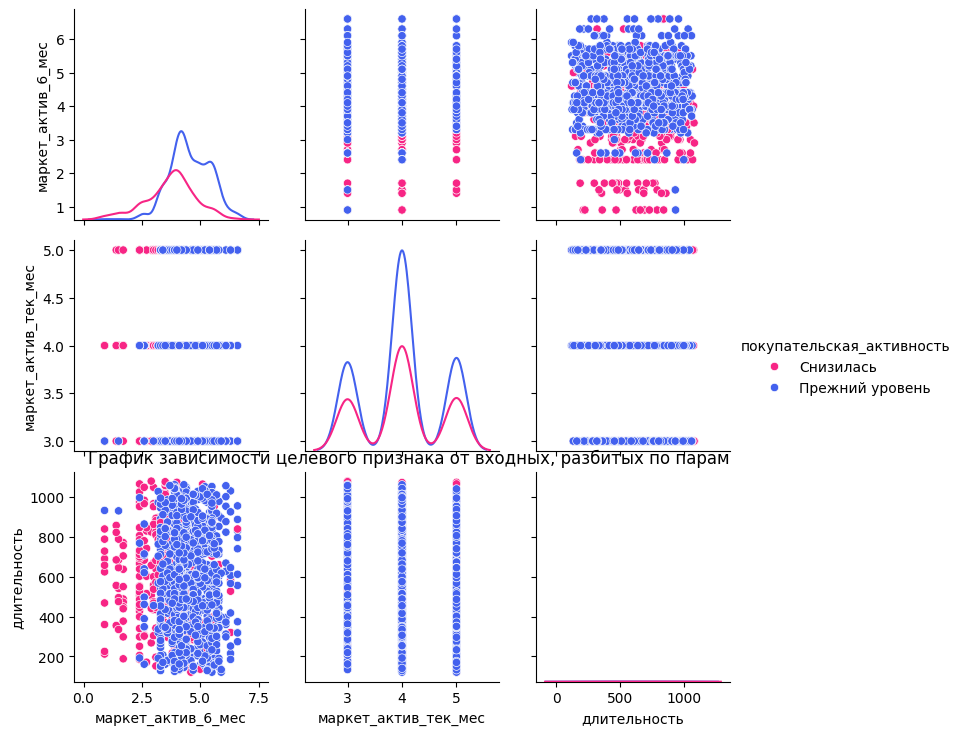

In [60]:
factor = ['маркет_актив_6_мес', 'маркет_актив_тек_мес',  'длительность']

g = sns.PairGrid(data=data, 
                 hue = 'покупательская_активность', 
                 x_vars=factor, 
                 y_vars=factor, 
                 palette=custom_palette)
plt.title('График зависимости целевого признака от входных, разбитых по парам', 
          y=1, 
          loc="right")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

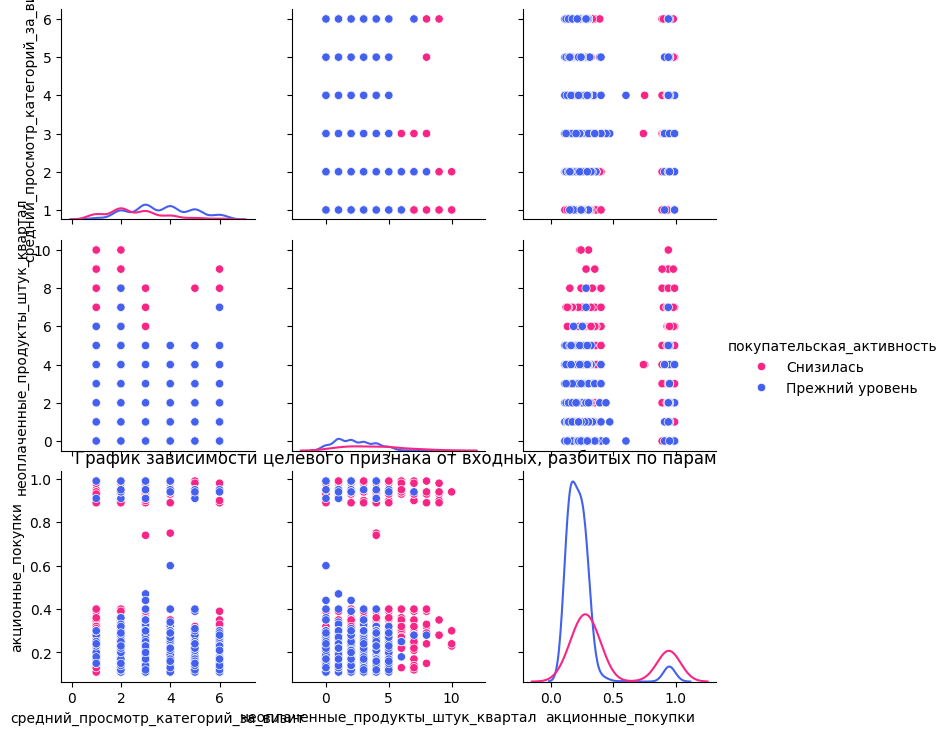

In [61]:
factor = ['средний_просмотр_категорий_за_визит', 
          'неоплаченные_продукты_штук_квартал', 
          'акционные_покупки',]

g = sns.PairGrid(data=data, 
                 hue = 'покупательская_активность', 
                 x_vars=factor, 
                 y_vars=factor, 
                 palette=custom_palette)
plt.title('График зависимости целевого признака от входных, разбитых по парам', 
          y=1, 
          loc="right")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

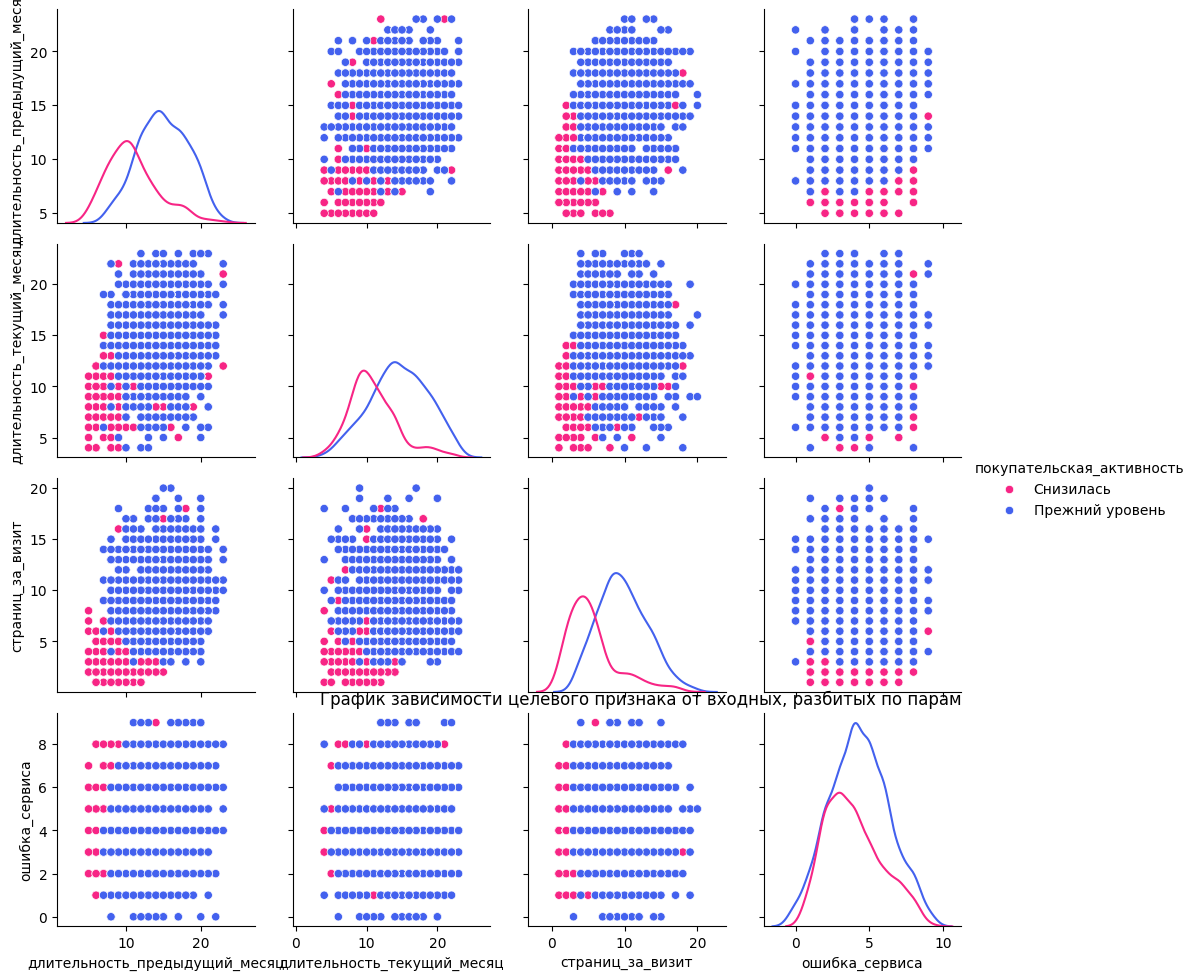

In [62]:
factor = ['длительность_предыдущий_месяц', 
          'длительность_текущий_месяц', 
          'страниц_за_визит', 
          'ошибка_сервиса',]

g = sns.PairGrid(data=data, 
                 hue = 'покупательская_активность', 
                 x_vars=factor, 
                 y_vars=factor, 
                 palette=custom_palette)
plt.title('График зависимости целевого признака от входных, разбитых по парам', 
          y=1, 
          loc="right")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

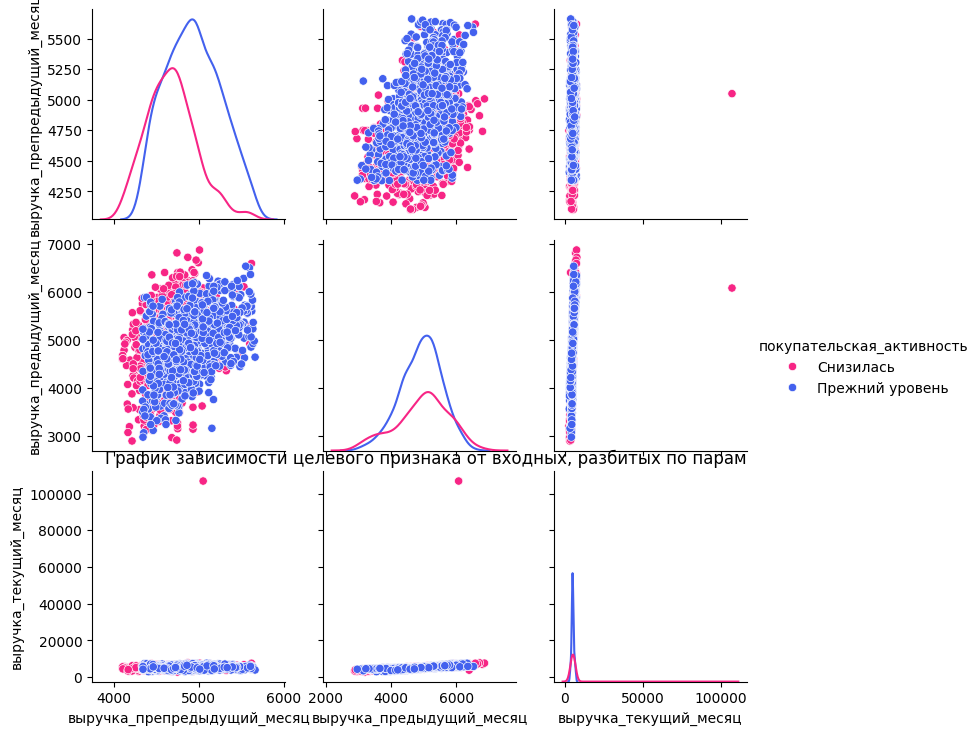

In [63]:
factor = ['выручка_препредыдущий_месяц',
          'выручка_предыдущий_месяц', 
          'выручка_текущий_месяц']
g = sns.PairGrid(data=data, 
                 hue = 'покупательская_активность', 
                 x_vars=factor, 
                 y_vars=factor, 
                 palette=custom_palette)
plt.title('График зависимости целевого признака от входных, разбитых по парам', 
          y=1, 
          loc="right")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

На графике видно, как распределились клиенты со сниженным уровнем активности и прежним уровнем при разных значениях входных признаков.
Четкая граница между целевыми признаками наблюдается на графиках с входными признаками:

-  'страниц_за_визит'
- 'ошибка_сервиса'
- 'неоплаченные_продукты_штук_квартал'
- 'средний_просмотр_категорий_за_визит'
- 'длительность_предыдущий_месяц'


На графиках входных признаков:

-'маркет_актив_6_мес'
-'акционные_покупки',
- 'выручки'
Каждый красный кружок среди большого количества синих — и наоборот — это и есть свидетельство нестандартной комбинации признаков. Необычные значения целевого признака, которые мешают линейной модели учиться. И которые сложно предсказать.

Можно предположить, что модель логистической регрессии будет плохо работать на данных признаках. 

## Обучение модели с использованием пайплайнов

Разделим датасет data на датасет с входными признаками и на датасет с целевым признаком

In [64]:
data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,длительность_предыдущий_месяц,длительность_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [65]:
X = data[['тип_сервиса', 
          'маркет_актив_6_мес',
          'маркет_актив_тек_мес', 
          'страниц_за_визит', 
          'акционные_покупки',
          'популярная_категория', 
          'средний_просмотр_категорий_за_визит',  
          'неоплаченные_продукты_штук_квартал', 
          'ошибка_сервиса', 
          'длительность_текущий_месяц',
          'длительность_предыдущий_месяц',
          'выручка_препредыдущий_месяц',
          'выручка_предыдущий_месяц',
          'выручка_текущий_месяц',
          ]]
y = data['покупательская_активность']

        
print('Размер датасета для обучения',X.shape)
print('Целевой признак',y.shape)


Размер датасета для обучения (1297, 14)
Целевой признак (1297,)


In [66]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=y)

In [67]:
y_train.head()

533     Прежний уровень
1117    Прежний уровень
565           Снизилась
1091    Прежний уровень
492           Снизилась
Name: покупательская_активность, dtype: object

In [68]:
label_encoder = LabelEncoder()
y_train_p = label_encoder.fit_transform(y_train)
y_test_p = label_encoder.transform(y_test)
#pd.DataFrame(y_train, y_train_p, columns=['LabelEncoder'])
y_train_p

array([0, 0, 1, ..., 0, 1, 0])

Инвертируем значение меток

In [69]:
y_train = 1 - y_train_p
y_test = 1 - y_test_p
y_train

array([1, 1, 0, ..., 1, 0, 1])

Избавимся от дисбаланска класса в целевом признаке с помощью оверсэмплинга

In [70]:
# создайте экземпляр класса RandomOverSampler с фиксированным random_state
sampler = RandomOverSampler(random_state=RANDOM_STATE)

# сэмплируйте данные методов оверсэмплинга одной командой
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

# выведите на экран распределения классов 
# в тренировочном датасете 
# до и после сэмплирования
print(f'Тренировочные данные до сэмплирования:\n{len(y_train)}')
print(f'\nТренировочные данные после сэмплирования:\n{len(y_train_sampled)}')

Тренировочные данные до сэмплирования:
1037

Тренировочные данные после сэмплирования:
1282


In [71]:
print('Размер обучающей выборки X_train/y_train:', 
      X_train.shape, 
      '/', 
      y_train.shape)
print('Размер X_test/y_test выборки:', 
      X_test.shape, 
      '/', 
      y_test.shape)

Размер обучающей выборки X_train/y_train: (1037, 14) / (1037,)
Размер X_test/y_test выборки: (260, 14) / (260,)


In [72]:
X_train = X_train_sampled
y_train = y_train_sampled

1. Признак: популярная_категория, будем кодировать с помощью OneHotEncoder
2. Признак: тип сервиса c помощью OrdinalEncoder
3. В данных признаках пропуски отсутсвуют, следовательно дополнительно нет необходимости их кодировать
4. Целевой признак - покупательская активность. Решаем задачу бинарной классификации.
5. Количественный признак - акционные_покупки, не требует масштабирования, т.к. это доля покупок по акции от общего числа (от 0 до 1)
6. Остальные количественные признаки требуют масштабирования. 

In [73]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = [
                'маркет_актив_6_мес',
                'страниц_за_визит',  
                'средний_просмотр_категорий_за_визит',  
                'неоплаченные_продукты_штук_квартал', 
                'ошибка_сервиса', 
                'длительность_предыдущий_месяц',
                'маркет_актив_тек_мес', 
                'длительность_текущий_месяц',
                'выручка_препредыдущий_месяц',
                'выручка_предыдущий_месяц',
                'выручка_текущий_месяц'
                ]
ohe_pipe = Pipeline(
    [
       
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: 
# заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)


In [74]:
# Закодированные и отмасштабированные признаки
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
) 

В качестве метрики будем использовать roc_auc,  это площадь под ROC-кривой, которая показывает зависимость TPR и FPR, поэтому она всегда даёт адекватную оценку качества модели.

In [75]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(),
                              'passthrough'], 
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly' ],
        #'models__C': [0.01,0.1,1,2,5],
        #'models__gamma': [0.01,0.1,1,2,5]
    },
    # словарь для модели LogisticRegression(penalty = 'l2')
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'] 
    },
    # словари для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, 
                                      solver='saga')],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'], 
        'models__penalty': ['l1', 'elasticnet']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, 
                                      solver='liblinear', 
                                      penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              'passthrough']  
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(),
                              'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=4,
    n_iter = 300,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_model = randomized_search.fit(X_train, y_train)
best_model=randomized_model.best_estimator_
best_score=randomized_model.best_score_
print('\nЛучшая модель и её параметры:\n\n', best_model) 
print('Метрика для лучшей модели:\n', best_score)


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                               

In [77]:
result = pd.DataFrame(randomized_model.cv_results_)
display(result[
    ['rank_test_score', 
     'param_models', 
     'mean_test_score',
     'params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
198,1,KNeighborsClassifier(),0.927128,"{'preprocessor__num': RobustScaler(), 'models_..."
90,2,KNeighborsClassifier(),0.926546,"{'preprocessor__num': StandardScaler(), 'model..."
47,3,DecisionTreeClassifier(random_state=42),0.923334,"{'preprocessor__num': MinMaxScaler(), 'models_..."
115,4,DecisionTreeClassifier(random_state=42),0.923218,"{'preprocessor__num': StandardScaler(), 'model..."
167,5,DecisionTreeClassifier(random_state=42),0.922266,"{'preprocessor__num': 'passthrough', 'models__..."
...,...,...,...,...
6,295,DecisionTreeClassifier(random_state=42),0.822376,"{'preprocessor__num': RobustScaler(), 'models_..."
222,297,DecisionTreeClassifier(random_state=42),0.821507,"{'preprocessor__num': RobustScaler(), 'models_..."
225,297,DecisionTreeClassifier(random_state=42),0.821507,"{'preprocessor__num': MinMaxScaler(), 'models_..."
62,297,DecisionTreeClassifier(random_state=42),0.821507,"{'preprocessor__num': RobustScaler(), 'models_..."


In [78]:
y_test_pred = best_model.predict(X_test)
print(f'Метрика roc_auc на тестовой выборке: \
       {roc_auc_score(y_test, y_test_pred).round(2)}')

Метрика roc_auc на тестовой выборке:        0.85


Лучшая модель выбрана (KNN) - это модель к-ближайших соседей. Масштабирование с помощью RobustScaler()

In [79]:
print('Точность модели:', best_score.round(2))
print('Смещение модели:', 
      (best_score - roc_auc_score(y_test, y_test_pred)).round(3)*100, '%')


Точность модели: 0.93
Смещение модели: 7.9 %


В процессе обучения выборка была избавлена от дисбаланса классов, путем увеличения минорного класса. Для уменьшения мажорного класса выборка недостаточного объема. 
Модель выбрана лучшая модель КNN . Модель достаточно хорошо обучена, нет признаков переобучения и недообученности. 

## Анализ важности признаков

Можем посмотреть список наиболее важных признаков, которые внесли больший вклад в модель с помощью SelectKBest.
После преобразования категориальных входных признаков на вход модель приняла 15 входных признаков. Посмотрим на первые 9, наиболее значимые.

In [80]:
# Выбор лучших k признаков
k = 9
selector = SelectKBest(k=k)
selector.fit(X_train_p, y_train)

features_names = selector.get_feature_names_out()
features_names

array(['ohe__популярная_категория_Мелкая бытовая техника и электроника',
       'num__маркет_актив_6_мес', 'num__страниц_за_визит',
       'num__средний_просмотр_категорий_за_визит',
       'num__неоплаченные_продукты_штук_квартал',
       'num__длительность_предыдущий_месяц',
       'num__длительность_текущий_месяц',
       'num__выручка_препредыдущий_месяц', 'remainder__акционные_покупки'],
      dtype=object)

Посмотрим на общий список значимости признаков и их вклад в модель.

In [81]:
model = best_model['models']
model.fit(X_train_p,y_train)
def f(x):
    return model.predict_proba(x)[:, 1]

med = X_train_p.median().values.reshape((1, X_train_p.shape[1]))

explainer = shap.Explainer(f, med)

shap_values = explainer(X_test_p.iloc[0:1000, :])


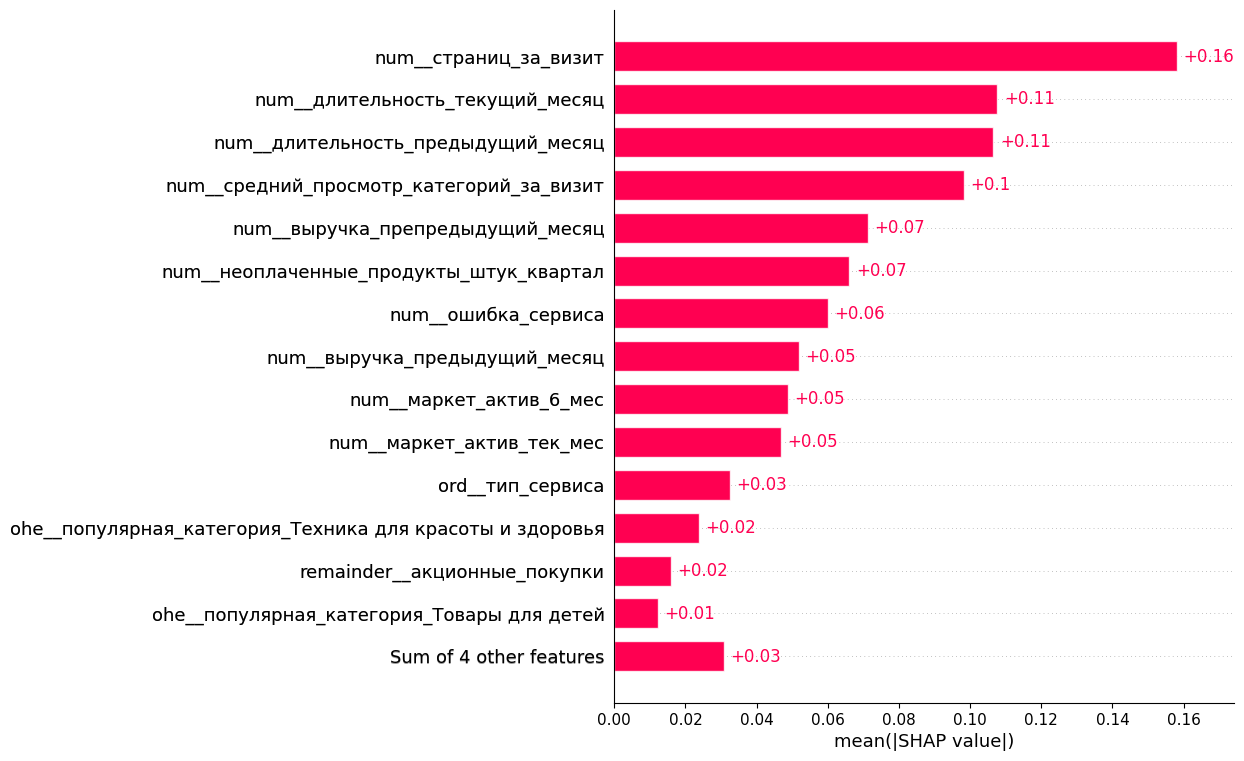

In [82]:
shap.plots.bar(shap_values, max_display=15) 

Признаки на графике расположены в порядке убывания их вклада: если убрать те, что наверху, качество модели просядет сильнее всего.


Перейдём к самому интересному — посмотрим, как признаки влияют на каждое предсказание модели:

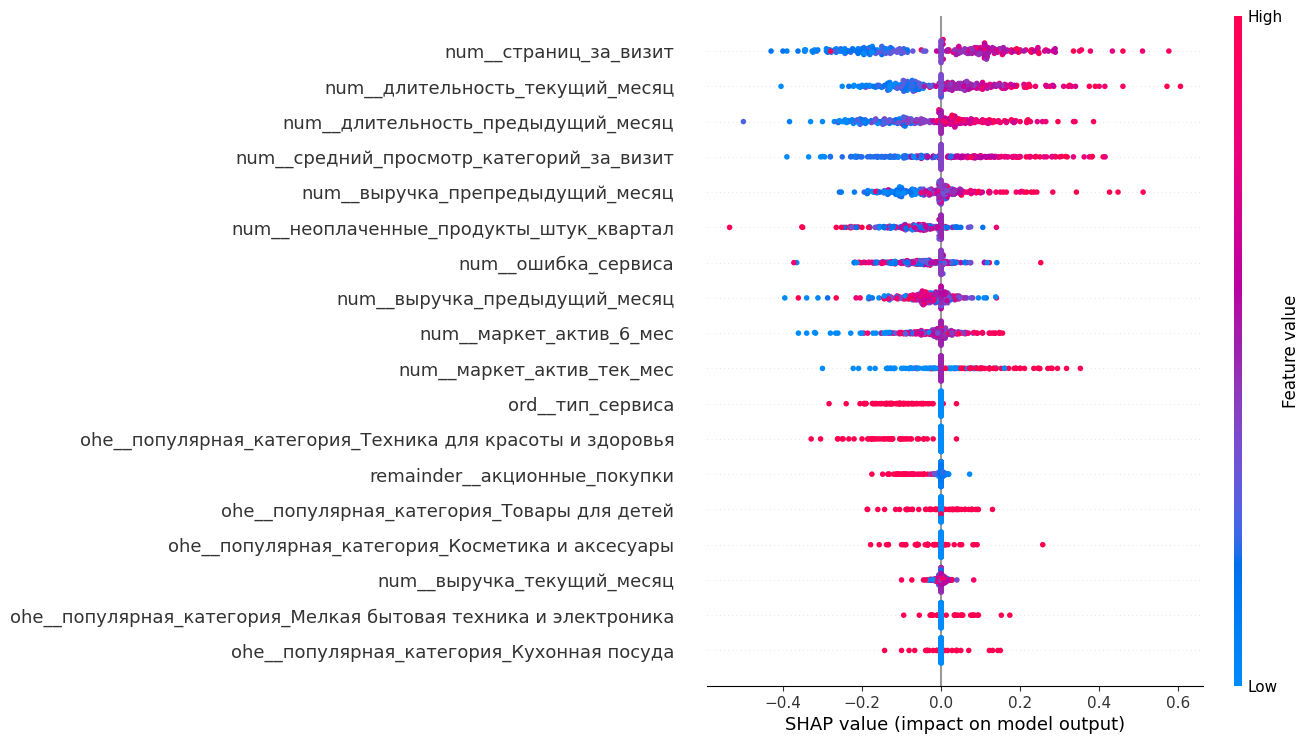

In [83]:
shap.plots.beeswarm(shap_values, max_display=19)

- Прежний уровень покупательской активности закодирован единицей (положительный окрас признака)
- Снизилась - 0 (негативный окрас)


Признаки сортируются по сумме величин их значений SHAP по всем образцам.
Входные признаки расположены в порядке их значимости для модели.


1. Мало времени проведенного на сайте - приводит к снижению покупательской активности, что вполне логично.
2. Мало просмотрено страниц за один визит. Оба эти признака в жизни взяаимосвязаны между собой.
3. Если клинет за один визит просматривает много категорий это увеличивает вероятность того, что модель отнесет ее к классу 1
4. Большое значение выручки за препредыдущий период имеет положительной окрас для модели
5. маркетинговая активность - ее большие значения имеют положительный окрас, модель смещается к классу 1

Интересно заметить, что тип сервиса 1 (премиум) напроитв смещает модель к негативному ответу

Кроме того, можно посмотреть, на основании чего модель присваивает тот или иной класс пользователю

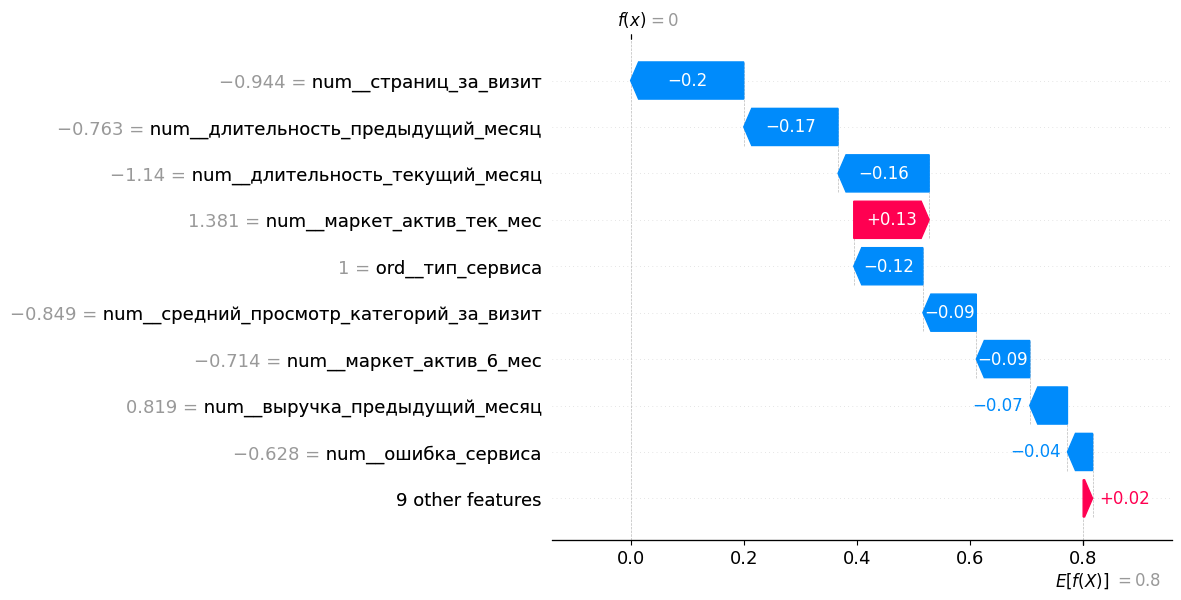

In [84]:
shap.plots.waterfall(shap_values[0])

Так, например, данному пользователю присвоен класс 0 (его покупательская активность снизилась)
Видно какие характеристики сдвинули решение модели в отрицательную сторону. 

Итак, чтобы сохранить покупательскую активность нужно, чтобы:
- покупатели больше времени проводили на сайте
- просматривали как можно больше категорий товаров.
- как можно больше страниц внутри каждой категории
- влиять на это можно с помощью маркетинговой активности (она на 6 месте в списке значимости)
- покупателей из категорий товары для детей и кухонная посуда надо постараться завлечь в другие категории товраов (смежные)

## Сегментация покупателей

### Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Объединим датасеты с покупателями и прибылью, которую они приносят компании

In [85]:
data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,длительность_предыдущий_месяц,длительность_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [86]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [87]:
data = pd.merge(data, money, on='id', how='left')

In [88]:
data = data.rename(
    columns={'покупательская активность': 'покупательская_активность', 
             'разрешить сообщать': 'разрешить_сообщать'
             })
data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,длительность_предыдущий_месяц,длительность_текущий_месяц,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,3.95


Отберем группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [89]:
low_activity = data.query('покупательская_активность == "Снизилась"')
low_activity.shape

(495, 19)

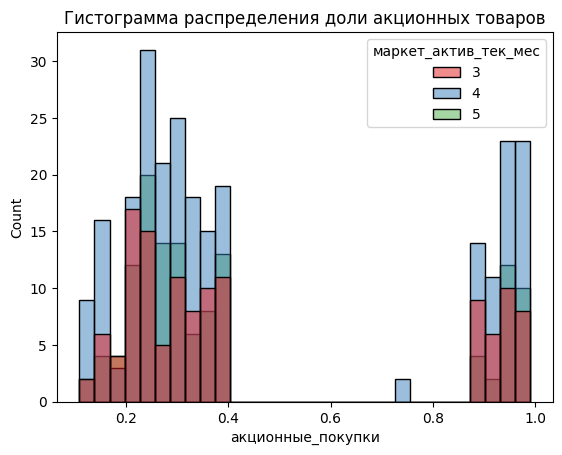

In [90]:
sns.histplot(low_activity, 
             x='акционные_покупки', 
             palette='Set1', 
             bins=30, 
             hue='маркет_актив_тек_мес')
plt.title('Гистограмма распределения доли акционных товаров')
plt.show()

Выделяется группа покупателей, которые берут приемущественно товары по акции (свыше 60% товаров куплено по акции). Выделяется группа покупателей, у которых в текущем месяце низкий показатель макретинговой активности.

In [91]:
segment_1 = low_activity.query('акционные_покупки > 0.6 '
'and маркет_актив_тек_мес <= 4 '
'and разрешить_сообщать == "да"')
segment_1.shape

(78, 19)

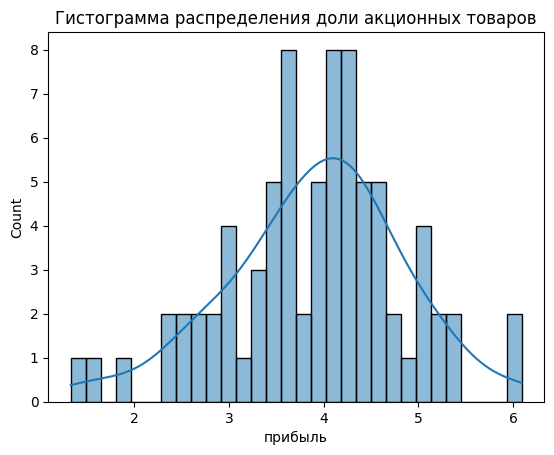

In [92]:
sns.histplot(segment_1, x='прибыль', palette='Set1', bins=30, kde=True)
plt.title('Гистограмма распределения доли акционных товаров')
plt.show()

segment_1 - группа из 65 покупателей (14.5% от числа со сниженной покупательской активностью), которые предпочитают брать товары по акции. При этом в этом месяце маркетинговая активность для них снижена. Данные покупатели дали свое разрешение на коммуникацию с компанией.

### Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

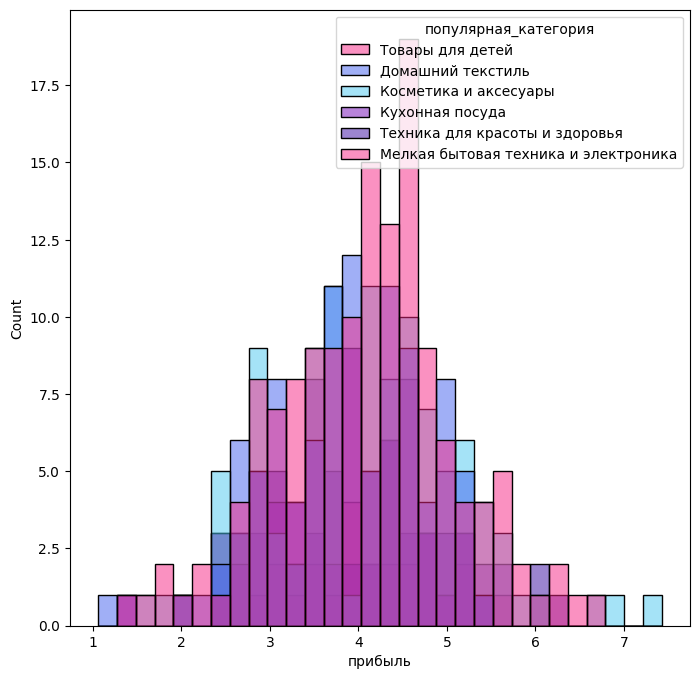

In [93]:
plt.figure(figsize=(8,8))
sns.histplot(low_activity, 
             x='прибыль', 
             palette=custom_palette, 
             bins=30, 
             hue='популярная_категория', 
             legend=True)
plt.show()

Отберем клиентов, с прибыльностью более 3 тыс. руб. как наиболее интересных. 

In [94]:
segment_2 = low_activity.query('прибыль >= 3 and разрешить_сообщать == "да"')
segment_2.shape

(311, 19)

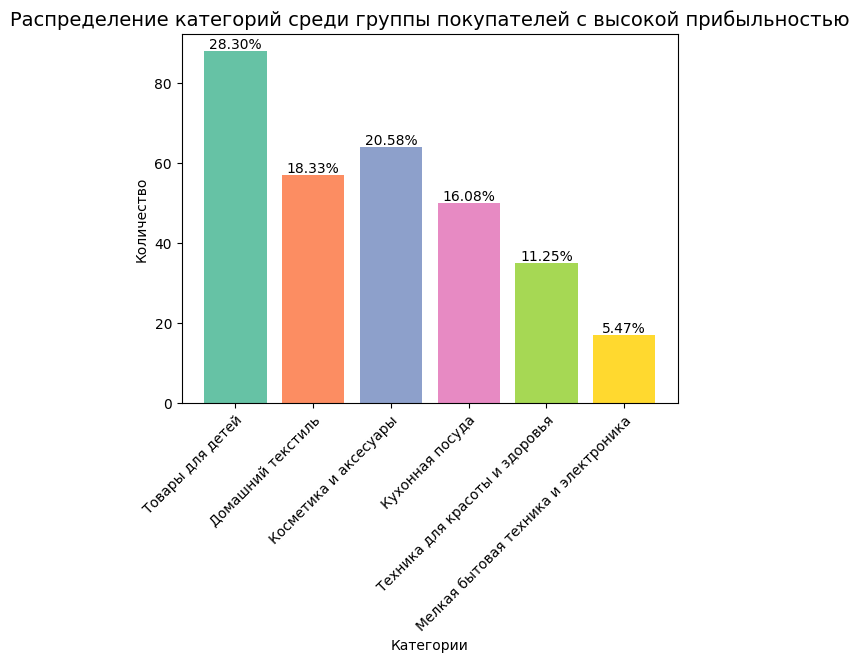

In [95]:
my_bar(
    segment_2['популярная_категория'], 
    'Распределение категорий среди группы покупателей с высокой прибыльностью'
    )

Треть группы покупателей с наиболее высокой прибыльностью предпочитают категорию товаров для детей. В тоже время из данных полученных с помощью модели именно в этой категории мы видим смещение модели в негативную сторону. Попробуем заинтересовать данных покупателей смежными товарами (например из категории косметика)

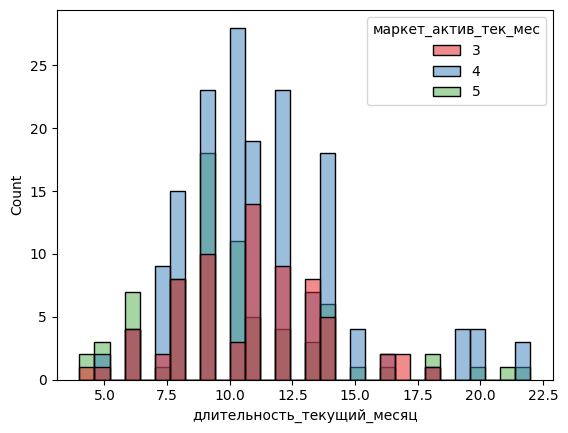

In [96]:
plt.figure()
ax=sns.histplot(segment_2, 
                x='длительность_текущий_месяц', 
                palette="Set1", 
                bins=30, 
                hue='маркет_актив_тек_мес')
plt.show()

Ислючим из группы клиентов с высокой макретинговой активностью в текущем месяце, чтобы не злоупотреблять доверием покупателя. 

In [97]:
segment_2['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Кухонная посуда', 'Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [98]:
segment_2 = segment_2.query('маркет_актив_тек_мес < 5 and \
                            популярная_категория == "Товары для детей"')
segment_2.shape

(61, 19)

segment_2 группа из 58 покупателей (14% от общего числа покупателей со сниженной активностью) с наиболее высокой прибыльностью, с разрешение на коммуникацию, со сниженным маркетинговым взаимодействием в текущем месяце сегментированная по популярной категории Товары для детей.

## Общий вывод



---

### **Цель исследования**  
Выявление ключевых факторов, снижающих покупательскую активность, и разработка стратегий для её повышения на основе данных.

---

### **Методология**  
1. **Предобработка данных**  
   - Очистка от выбросов.  
   - Устранение дисбаланса классов методом *oversampling* (клонирование минорного класса целевой переменной).  

2. **Моделирование**  
   - Тестирование алгоритмов: сравнение моделей по метрике **ROC-AUC**.  
   - Лучшая модель: **KNN**.  
   - Качество модели:  
     - ROC-AUC: **93%**  
     

---

### **Интерпретация результатов (SHAP-анализ)**  
1. **Факторы снижения активности**  
   - 🔍 Низкое время пребывания на сайте.  
   - 🔍 Минимальное количество просмотренных страниц и категорий.  
   - 🔍 Слабая реакция на маркетинговые активности.  
   - 🔍 Ограниченная история покупок.  

2. **Ключевые сегменты клиентов**  
   - 🎯 **«Акционные покупатели»**: чувствительны к скидкам, реагируют на частые коммуникации.  
   - 🎯 **«Премиум-клиенты»**: высокодоходная аудитория, приобретающая товары для детей.  

---

### **Рекомендации**  
**Для сегмента «Акционные покупатели»**  
   - ✅ Персонализированные промо-предложения.  
   - ✅ Увеличение частоты email-рассылок и push-уведомлений.  
   - ✅ Создание программы лояльности с бонусами за повторные покупки.  

**Для сегмента «Премиум-клиенты»**  
   - ✅ Расширение ассортимента товаров премиум-класса.  
   - ✅ Специальные предложения на сопутствующие категории (например, товары для дома).  
   - ✅ Эксклюзивные условия доставки и сервиса.  

**Общие улучшения**  
   - 🌐 Оптимизация навигации на сайте (уменьшение времени поиска товаров).  
   - 📊 Внедрение AI-рекомендательной системы.  
   - 📈 Стимулирование повторных покупок через персональные рассылки.  

